# Prediction tests Etienne
Using python

In [39]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from haversine import haversine

import os

In [40]:
os.getcwd()
#os.chdir()

'C:\\Users\\Etienne Jenner\\Documents\\3A - Télécom Bretagne\\Fouilles\\Projet NY Taxi'

In [22]:
train_dataset_raw = pd.read_csv('NYtaxy/data/train.csv')
train_dataset_raw.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Reduce the dataset to be much smaller for working purposes

In [58]:
N = 1200000

train_dataset = train_dataset_raw.sample(N)

## Filter errornous values

In [59]:
#train_dataset = train_dataset_raw

# Trips too long
MAX_TRIP_DURATION = 2 * 3600
MIN_TRIP_DURATION = 30
train_dataset = train_dataset[
    (train_dataset.trip_duration < MAX_TRIP_DURATION) &
    (train_dataset.trip_duration > MIN_TRIP_DURATION)
]

In [25]:
#df = pd.DataFrame([[4, 9],] * 3, columns=['A', 'B']); print (df)
#df.apply(lambda x: [1, 2], axis=1)

## Create new features

In [60]:
# Harvesine Distance

def create_distance(df):
    df['havers_dist'] = df.apply(lambda x: haversine(
        (x['pickup_latitude'], x['pickup_longitude']),
        (x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)

create_distance(train_dataset)

In [61]:
def create_datetime(df):

    df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])

    # Hour of the day
    df['pickup_seconds'] = (
        df['pickup_datetime'].dt.second +
        df['pickup_datetime'].dt.minute * 60 +
        df['pickup_datetime'].dt.hour * 60 * 60
    )

    # Day and month
    df['pickup_weekday'] = df['pickup_datetime'].dt.dayofweek;
    df['pickup_month'] = df['pickup_datetime'].dt.month


def create_log_trip_duration(df):
    # Log trip_duration
    df['log_trip_duration'] = np.log(df["trip_duration"])

create_datetime(train_dataset)
create_log_trip_duration(train_dataset)

In [62]:
def create_speed(df):
    #calcul de la vitesse moyenne pour une course
    df['speed'] = df['havers_dist']/df['trip_duration']
    
def create_hour(df):
    #calcul de la tranche horaire du pickup (en heure)
    df['pickup_hour']=df['pickup_datetime'].dt.hour

def create_meanspeedhour_list(df):
    #création d'une liste des meanspeedhour associées à chaque heure et jour
    for j in range (0,7):
        heure0 = round(df['speed'][(df['pickup_hour'] == 0) & (df['pickup_weekday'] == j)].mean(),6)
        MSH_list.append([heure0])
        for i in range(1,24):
            MSH_list[j].append(round(df['speed'][(df['pickup_hour'] == i) & (df['pickup_weekday'] == j)].mean(),6))
        
    print(MSH_list)
        
def create_meanspeedhour(df):
    df['average_speed']=df['pickup_hour']
    for i in range(0,24):
        for j in range (0,7):
            df['average_speed'][(df['pickup_hour'] == i) & (df['pickup_weekday'] == j)] = MSH_list[j][i]
            
def create_average_duration(df):
    df['average_duration']=df['havers_dist']/df['average_speed']

create_speed(train_dataset)
create_hour(train_dataset)
MSH_list=[];
create_meanspeedhour_list(train_dataset)
create_meanspeedhour(train_dataset)
create_average_duration(train_dataset)

[[0.006223, 0.00615, 0.006059, 0.006202, 0.007103, 0.007014, 0.005679, 0.004352, 0.003533, 0.003404, 0.003476, 0.003521, 0.003488, 0.003634, 0.003572, 0.003524, 0.00365, 0.003615, 0.003871, 0.004209, 0.004711, 0.004849, 0.004977, 0.005475], [0.005766, 0.00603, 0.006037, 0.006309, 0.006917, 0.00673, 0.0054, 0.004037, 0.003176, 0.003025, 0.003004, 0.003001, 0.003028, 0.003124, 0.003146, 0.003095, 0.003295, 0.003275, 0.003342, 0.003861, 0.004334, 0.00455, 0.004706, 0.005121], [0.005377, 0.005809, 0.005986, 0.006073, 0.006766, 0.006673, 0.005484, 0.004046, 0.003251, 0.003031, 0.003002, 0.002963, 0.002915, 0.003013, 0.003007, 0.002996, 0.003186, 0.003134, 0.003226, 0.003645, 0.004329, 0.004436, 0.004497, 0.004845], [0.005248, 0.005731, 0.005838, 0.006239, 0.006689, 0.006762, 0.005502, 0.004064, 0.003188, 0.003053, 0.003054, 0.003001, 0.002992, 0.003124, 0.003039, 0.003043, 0.003176, 0.003172, 0.003272, 0.003568, 0.004042, 0.004199, 0.004263, 0.00458], [0.004874, 0.00523, 0.005381, 0.005638,

C:\Users\Etienne Jenner\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Etienne Jenner\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [63]:
train_dataset.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,havers_dist,pickup_seconds,pickup_weekday,pickup_month,log_trip_duration,speed,pickup_hour,average_speed,average_duration
1100491,id3746359,2,2016-03-16 20:36:10,2016-03-16 20:44:12,1,-73.955750,40.776310,-73.952652,40.808079,N,482,3.542145,74170,2,3,6.177944,0.007349,20,0.004329,818.236427
695549,id3340845,2,2016-05-07 13:38:10,2016-05-07 14:01:11,1,-73.996857,40.752548,-74.016060,40.710899,N,1381,4.905680,49090,5,5,7.230563,0.003552,13,0.003735,1313.435155
1303577,id2544656,2,2016-03-07 19:26:30,2016-03-07 19:30:14,1,-73.987640,40.755299,-73.987694,40.748081,N,224,0.802553,69990,0,3,5.411646,0.003583,19,0.004209,190.675406
913684,id3798982,1,2016-02-14 19:07:44,2016-02-14 19:15:07,1,-73.967087,40.769962,-73.966690,40.762112,N,443,0.873592,68864,6,2,6.093570,0.001972,19,0.004281,204.062714
194429,id0373463,2,2016-02-08 10:09:52,2016-02-08 10:23:29,6,-73.982315,40.777119,-73.979118,40.757553,N,817,2.192190,36592,0,2,6.705639,0.002683,10,0.003476,630.664480


In [30]:
#sns.scatterplot(x="pickup_hour", y="meanspeedhour", data=train_dataset)

In [64]:
len(train_dataset['log_trip_duration'])

1194075

# Filter erronous values (after feature engineering)

In [65]:
msk = np.random.rand(len(train_dataset)) < 0.9

train_set = train_dataset[msk]
test_set = train_dataset[~msk]

In [67]:
train_data = train_set[[
        'vendor_id',
        'passenger_count',
        'pickup_longitude',
        'pickup_latitude',
        'dropoff_longitude',
        'dropoff_latitude',
        # 'trip_duration',
        'havers_dist',
        'pickup_seconds',
        'pickup_weekday',
        'pickup_month',
        # 'log_trip_duration',
        'average_speed',
        'average_duration'
    ]]
train_label = train_set['log_trip_duration']
dtrain = xgb.DMatrix(train_data, label=train_label)

test_data = test_set[[
        'vendor_id',
        'passenger_count',
        'pickup_longitude',
        'pickup_latitude',
        'dropoff_longitude',
        'dropoff_latitude',
        # 'trip_duration',
        'havers_dist',
        'pickup_seconds',
        'pickup_weekday',
        'pickup_month',
        # 'log_trip_duration',
        'average_speed',
        'average_duration'
    ]]
test_label = test_set['log_trip_duration']
dtest = xgb.DMatrix(test_data, label=test_label)

In [68]:
param = {
    #'lambda': .1,
    #'alpha': .1,
    #'feature_selector': 'shuffle',
    #'objective': 'reg:linear',
    #'nthread': 4
    
    'min_child_weight': 10, 'eta': 0.03, 'colsample_bytree': 0.3, 'max_depth': 10,
    'subsample': 0.8, 'lambda': 1, 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
    'eval_metric': 'rmse', 'objective': 'reg:linear'
}
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 300

bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-rmse:5.83711	train-rmse:5.83717
[1]	eval-rmse:5.66281	train-rmse:5.66289
[2]	eval-rmse:5.4938	train-rmse:5.4939
[3]	eval-rmse:5.33064	train-rmse:5.33075
[4]	eval-rmse:5.17167	train-rmse:5.17179
[5]	eval-rmse:5.0189	train-rmse:5.01902
[6]	eval-rmse:4.87103	train-rmse:4.87114
[7]	eval-rmse:4.72767	train-rmse:4.72777
[8]	eval-rmse:4.58682	train-rmse:4.58694
[9]	eval-rmse:4.45207	train-rmse:4.45219
[10]	eval-rmse:4.31958	train-rmse:4.31971
[11]	eval-rmse:4.19291	train-rmse:4.19304
[12]	eval-rmse:4.06989	train-rmse:4.07006
[13]	eval-rmse:3.949	train-rmse:3.94918
[14]	eval-rmse:3.83324	train-rmse:3.83342
[15]	eval-rmse:3.71952	train-rmse:3.71972
[16]	eval-rmse:3.60914	train-rmse:3.60938
[17]	eval-rmse:3.50376	train-rmse:3.504
[18]	eval-rmse:3.4014	train-rmse:3.40166
[19]	eval-rmse:3.3023	train-rmse:3.30258
[20]	eval-rmse:3.20465	train-rmse:3.20493
[21]	eval-rmse:3.11156	train-rmse:3.11187
[22]	eval-rmse:3.01988	train-rmse:3.02021
[23]	eval-rmse:2.93088	train-rmse:2.93122
[24]	eval-r

[189]	eval-rmse:0.368745	train-rmse:0.36329
[190]	eval-rmse:0.368422	train-rmse:0.36288
[191]	eval-rmse:0.368314	train-rmse:0.362718
[192]	eval-rmse:0.368264	train-rmse:0.362643
[193]	eval-rmse:0.368109	train-rmse:0.362449
[194]	eval-rmse:0.368002	train-rmse:0.362294
[195]	eval-rmse:0.367902	train-rmse:0.362143
[196]	eval-rmse:0.367872	train-rmse:0.362106
[197]	eval-rmse:0.367749	train-rmse:0.361917
[198]	eval-rmse:0.367624	train-rmse:0.361758
[199]	eval-rmse:0.367505	train-rmse:0.361578
[200]	eval-rmse:0.367367	train-rmse:0.361381
[201]	eval-rmse:0.367205	train-rmse:0.361189
[202]	eval-rmse:0.36714	train-rmse:0.361104
[203]	eval-rmse:0.367017	train-rmse:0.360944
[204]	eval-rmse:0.366912	train-rmse:0.360806
[205]	eval-rmse:0.366839	train-rmse:0.360707
[206]	eval-rmse:0.366788	train-rmse:0.360633
[207]	eval-rmse:0.366716	train-rmse:0.360518
[208]	eval-rmse:0.366689	train-rmse:0.360471
[209]	eval-rmse:0.366617	train-rmse:0.360348
[210]	eval-rmse:0.36648	train-rmse:0.360172
[211]	eval-rms

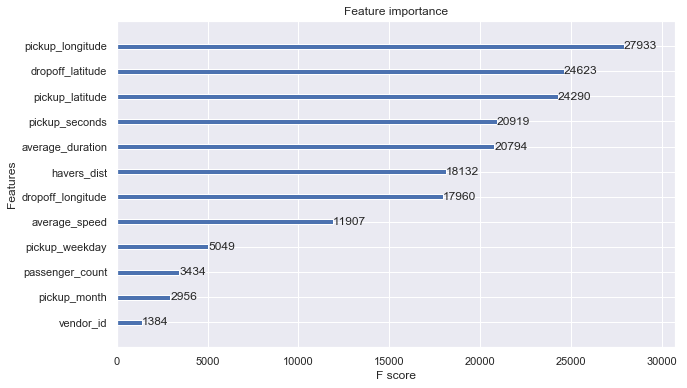

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(bst, ax=ax)

## Prediction

In [36]:
test_dataset_raw = pd.read_csv('NYtaxy/data/test.csv')

In [37]:
test_dataset = test_dataset_raw

create_distance(test_dataset)
create_datetime(test_dataset)
create_hour(test_dataset)
create_meanspeedhour(test_dataset)

C:\Users\Etienne Jenner\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Etienne Jenner\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [38]:
dtest = xgb.DMatrix(test_dataset[[
        'vendor_id',
        'passenger_count',
        'pickup_longitude',
        'pickup_latitude',
        'dropoff_longitude',
        'dropoff_latitude',
        'havers_dist',
        'pickup_seconds',
        'pickup_weekday',
        'pickup_month',
        'meanspeedhour'
    ]])
ypred = bst.predict(dtest)

ValueError: feature_names mismatch: ['vendor_id', 'passenger_count', 'havers_dist', 'pickup_seconds', 'pickup_weekday', 'pickup_month', 'meanspeedhour'] ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'havers_dist', 'pickup_seconds', 'pickup_weekday', 'pickup_month', 'meanspeedhour']
training data did not have the following fields: pickup_latitude, dropoff_longitude, dropoff_latitude, pickup_longitude

In [ ]:
prediction_result = np.round(np.exp(ypred))

In [ ]:
prediction_df = test_dataset
prediction_df['trip_duration'] = prediction_result

prediction_df.to_csv("submition4.csv", columns=['id', 'trip_duration'], index=False)